## Time Series Analysis

#### Seasonal Decomposition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from dateutil.parser import parse

# Import Data
df = pd.read_csv('../data/time-series-seasonality/seasonal-data.csv', parse_dates=['Date'], index_col='Date')
df.reset_index(inplace=True)
df.head()

,Date,Temp-Final
0,2014-01-01 01:00:00,27.974586
1,2014-01-01 02:00:00,26.040642
2,2014-01-01 03:00:00,24.073209
3,2014-01-01 04:00:00,26.021572
4,2014-01-01 05:00:00,27.936445


In [2]:
df.dtypes

Date          datetime64[ns]
Temp-Final           float64
dtype: object

<Axes: xlabel='Date'>

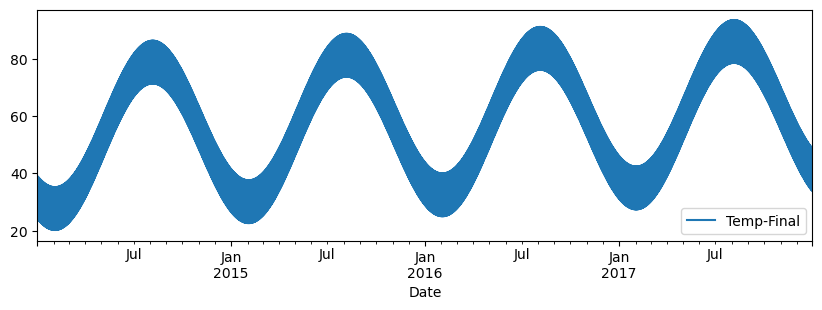

In [3]:
# Shows Yearly cyclic nature in this graph
plt.rcParams.update({'figure.figsize': (10,3)})
df.set_index('Date').plot()

<Axes: xlabel='Date'>

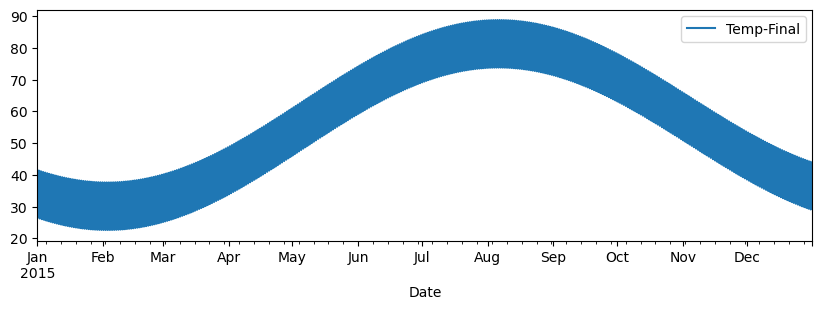

In [4]:
# No additional cyclic trends
plt.rcParams.update({'figure.figsize': (10,3)})
monthly = df[df['Date'].dt.year == 2015 ]
monthly.set_index('Date').plot()

<Axes: xlabel='Date'>

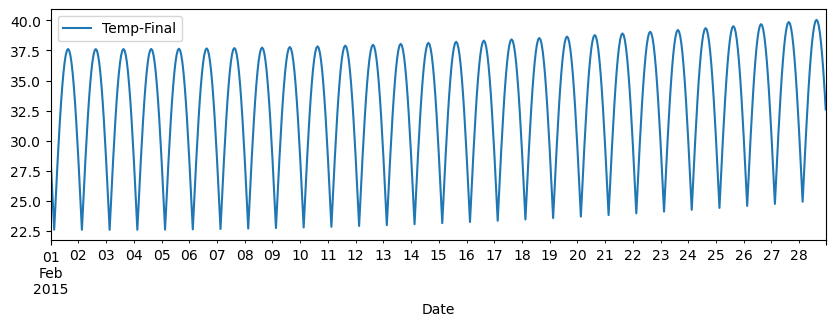

In [5]:
# Shows daily trend
plt.rcParams.update({'figure.figsize': (10,3)})
monthly = df[ (df['Date'].dt.year == 2015) & (df['Date'].dt.month == 2) ]
monthly.set_index('Date').plot()

- This indicates that the data has an annual and daily cyclic trend.  

### Using STL

**One Year Cycle Selection**
 - period = 24x7x52 = 8736 data points in a cycle (1 year)  
 OR
 - period = 24x365 = 8760

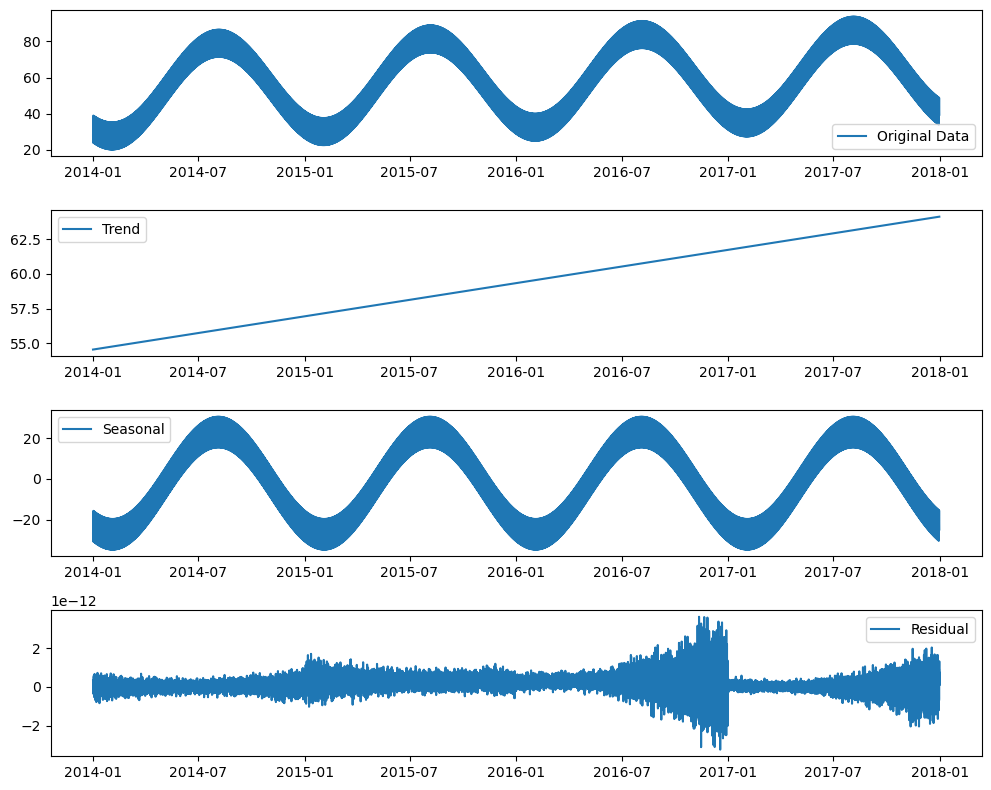

In [6]:
from statsmodels.tsa.seasonal import STL
stl = STL(df['Temp-Final'], period=365*24)
result = stl.fit()

# Plot the decomposition components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df['Date'], df['Temp-Final'], label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df['Date'], result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df['Date'], result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df['Date'], result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

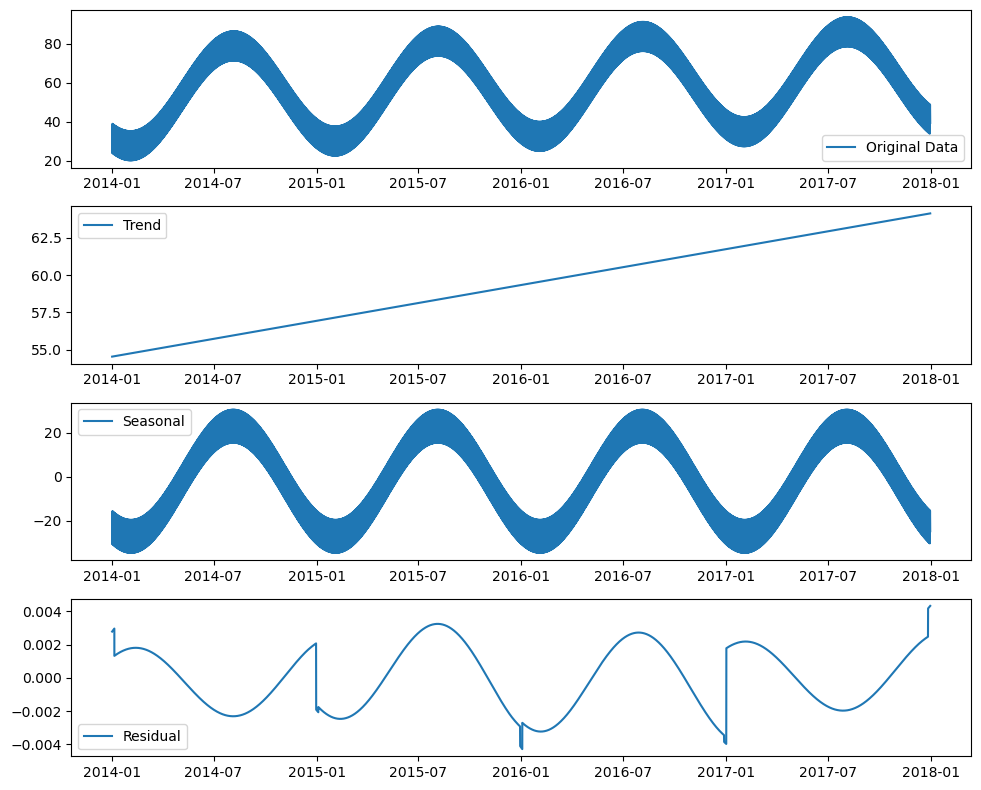

In [7]:
from statsmodels.tsa.seasonal import STL
stl = STL(df['Temp-Final'], period=24*7*52)
result = stl.fit()

# Plot the decomposition components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df['Date'], df['Temp-Final'], label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df['Date'], result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df['Date'], result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df['Date'], result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

**Note**:  Using a period of 24*7*52 produces a much smaller residual - almost non-existent residual.  

There should be a simple way of determining the optimum seasonality.  I tried having STL automatically determine it but received an error.  I believe the error was generated because the data contains multiple cyclic trends - yearly and daily.

There should be a procedure or existing method to deal with multi-seasonal data.

### Estimation of Linear Trend

In [8]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(df.index, result.trend)

dictionary = {
    "slope": slope,
    "intercept": intercept,
    "r_value": r_value,
    "p_value": p_value,
    "std_err": std_err
}

dictionary

{'slope': 0.0002738995835214489,
 'intercept': 54.53715206011234,
 'r_value': 0.9999999826787036,
 'p_value': 0.0,
 'std_err': 2.7234971030249493e-10}

<Axes: xlabel='Date'>

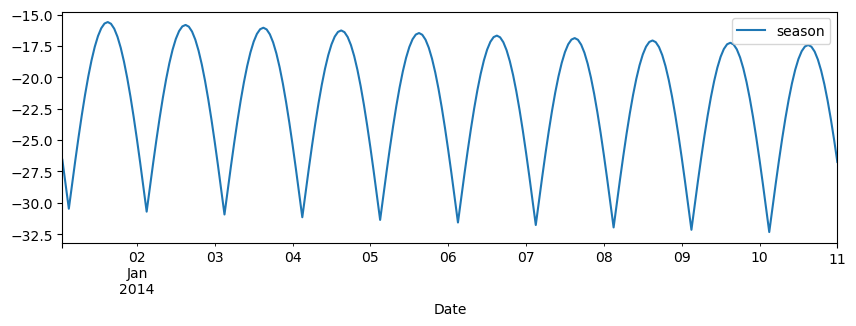

In [9]:
df_seasonal = pd.concat([df.Date, result.seasonal], axis=1)
df_seasonal.set_index('Date')[0:240].plot()

### Estimation of Seasonal Trend (Annual + Daily)

<Axes: xlabel='Date'>

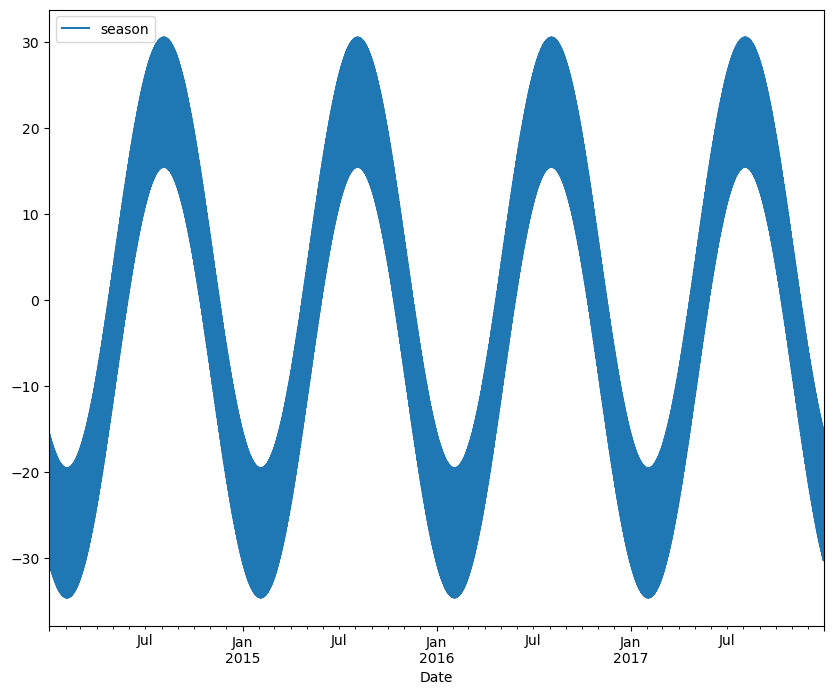

In [10]:
df_seasonal.set_index('Date').plot(figsize=(10, 8))

C:\Users\ejwda\AppData\Local\Temp\ipykernel_4148\1867193272.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df_seasonal.groupby(df.Date.dt.date).mean()


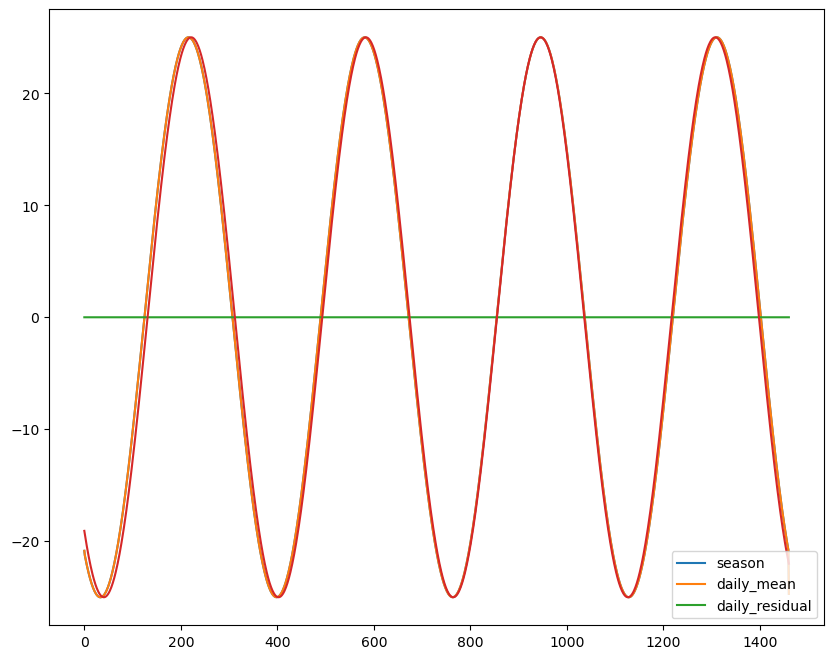

In [55]:
# Remove Daily Cyclic by taking a daily average

# setup plot
fig, ax = plt.subplots(figsize=(10, 8))

# Real data daily averaged data
temp = df_seasonal.groupby(df.Date.dt.date).mean()
temp.reset_index(inplace=True)
temp.plot(figsize=(10, 8), ax=ax)

# estimated annaul trend using daily inputs - mathematical model
annual_cycle = lambda x: 25*np.sin(np.pi*(x-131)/181)
ax.plot(temp.index, annual_cycle(temp.index), label='estimated curve')

The above chart shows that the mathematical model fits the annual cyclic trend very well

In [13]:
# Remove the annual cyclic trend from the seasonal trend (contains both annual and daily cyclic trends) 
# Seasonal_trend = annual_cyclic + daily_cyclic  therefore daily_cyclic is the residual of seasonal_trend less annual_cyclick
df_seasonal['daily_mean'] = df_seasonal.groupby(df.Date.dt.date).transform('mean')
df_seasonal['daily_residual'] = df_seasonal['season'] - df_seasonal['daily_mean']
df_seasonal.head()

C:\Users\ejwda\AppData\Local\Temp\ipykernel_4148\3764159601.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_seasonal['daily_mean'] = df_seasonal.groupby(df.Date.dt.date).transform('mean')


,Date,season,daily_mean,daily_residual
0,2014-01-01 01:00:00,-26.566586,-20.855463,-5.711123
1,2014-01-01 02:00:00,-28.500806,-20.855463,-7.645343
2,2014-01-01 03:00:00,-30.468515,-20.855463,-9.613052
3,2014-01-01 04:00:00,-28.520428,-20.855463,-7.664965
4,2014-01-01 05:00:00,-26.605829,-20.855463,-5.750366


<Axes: >

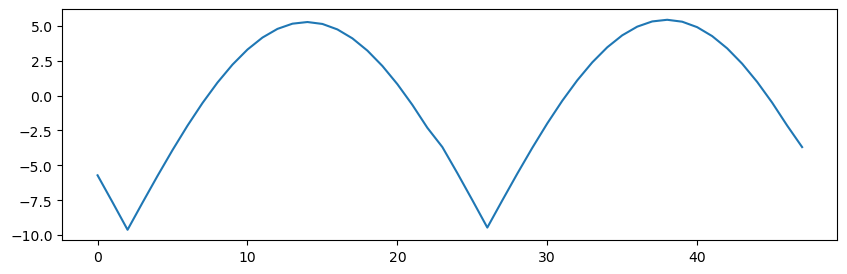

In [53]:
# review residual
df_seasonal['daily_residual'][0:48].plot(figsize=(10,3))

<Axes: xlabel='Date'>

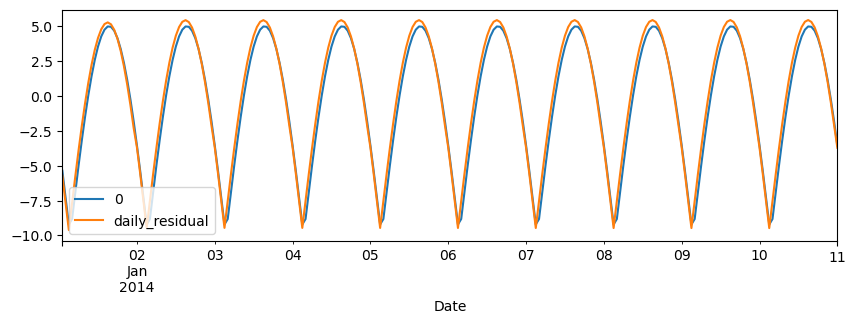

In [54]:
#model daily cyclic trend

# setup plot
fig, ax = plt.subplots()

# create mathematical model with hourly input data
x = np.arange(0,240)
daily_cycle = lambda x: abs(15*np.sin(np.pi*(x/24-0.1)))-10
df1 = pd.concat([df['Date'][0:240].reset_index(drop=True), pd.Series(daily_cycle(x[0:240])).reset_index(drop=True)], axis=1)
df1.set_index('Date').plot(ax=ax, label='estimated curve')

# plot original data
df2 = pd.concat([df_seasonal.Date, df_seasonal['daily_residual']], axis=1)
df2.set_index('Date')[0:240].plot(ax=ax)

Shows model fits the daily cyclic trend well

In [16]:
# create a running total of days and hours from the initial date
# the hourly calc will math the index of the dataframe used above and can be used when apply the mathematical models
df['days'] = (df['Date'] - df['Date'].min()).dt.days
df['hours'] = (df['Date'] - df['Date'].min()).dt.total_seconds()/3600
df.tail()

,Date,Temp-Final,days,hours
35035,2017-12-30 20:00:00,45.640519,1459,35035.0
35036,2017-12-30 21:00:00,44.337216,1459,35036.0
35037,2017-12-30 22:00:00,42.852441,1459,35037.0
35038,2017-12-30 23:00:00,41.211436,1459,35038.0
35039,2017-12-31 00:00:00,39.442115,1459,35039.0


In [18]:
df.head()

,Date,Temp-Final,days,hours
0,2014-01-01 01:00:00,27.974586,0,0.0
1,2014-01-01 02:00:00,26.040642,0,1.0
2,2014-01-01 03:00:00,24.073209,0,2.0
3,2014-01-01 04:00:00,26.021572,0,3.0
4,2014-01-01 05:00:00,27.936445,0,4.0


In [41]:
# collect all models here and create df columns for each estimator  
linear_eqn = {'slope': 0.0002738995835214489,'intercept': 54.53715206011234}

linear_trend = lambda hour: linear_eqn['slope'] * hour + linear_eqn['intercept']
annual_cycle = lambda day: 25*np.sin(np.pi*(day-131)/181)
daily_cycle = lambda x: abs(15*np.sin(np.pi*(x/24-0.1)))-10

df = df.assign(est_linear = lambda t: linear_trend(t['hours']) )
df = df.assign(est_annual_cycle = lambda t: annual_cycle(t['days']) )
df = df.assign(est_daily_cycle = lambda t: daily_cycle(t['hours']) )
df = df.assign(est_Temp = lambda t: linear_trend(t['hours']) + annual_cycle(t['days']) + daily_cycle(t['hours']))

df['summed_Temps'] = df['est_linear'] + df['est_annual_cycle'] + df['est_daily_cycle'] 

df.head()

,Date,Temp-Final,days,hours,est_linear,est_annual_cycle,est_daily_cycle,est_Temp,summed_Temps
0,2014-01-01 01:00:00,27.974586,0,0.0,54.537152,-19.073411,-5.364745,30.098996,30.098996
1,2014-01-01 02:00:00,26.040642,0,1.0,54.537426,-19.073411,-7.266467,28.197548,28.197548
2,2014-01-01 03:00:00,24.073209,0,2.0,54.537700,-19.073411,-9.214961,26.249328,26.249328
3,2014-01-01 04:00:00,26.021572,0,3.0,54.537974,-19.073411,-8.823114,26.641449,26.641449
4,2014-01-01 05:00:00,27.936445,0,4.0,54.538248,-19.073411,-6.881325,28.583512,28.583512


In [42]:
df.tail()

,Date,Temp-Final,days,hours,est_linear,est_annual_cycle,est_daily_cycle,est_Temp,summed_Temps
35035,2017-12-30 20:00:00,45.640519,1459,35035.0,64.133224,-21.793823,2.361893,44.701294,44.701294
35036,2017-12-30 21:00:00,44.337216,1459,35036.0,64.133498,-21.793823,1.147172,43.486847,43.486847
35037,2017-12-30 22:00:00,42.852441,1459,35037.0,64.133772,-21.793823,-0.258279,42.081670,42.081670
35038,2017-12-30 23:00:00,41.211436,1459,35038.0,64.134046,-21.793823,-1.830414,40.509808,40.509808
35039,2017-12-31 00:00:00,39.442115,1459,35039.0,64.134320,-21.793823,-3.542334,38.798163,38.798163


<Axes: xlabel='Date'>

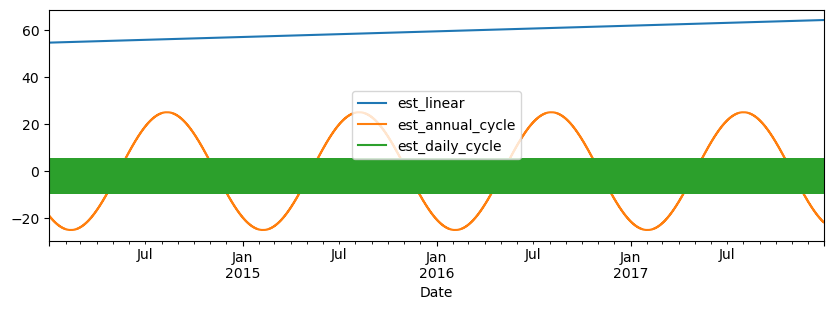

In [44]:
# show all trends individually
df[['Date','est_linear', 'est_annual_cycle', 'est_daily_cycle']].set_index('Date').plot()

The above trends look promising - the magnitudes and periods look appropriate 

<Axes: xlabel='Date'>

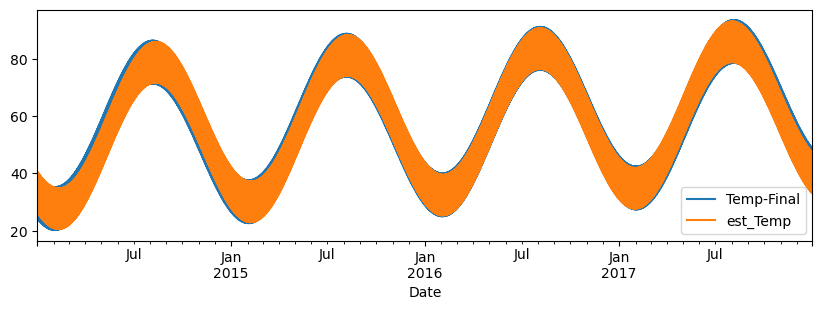

In [45]:
df[['Date','Temp-Final', 'est_Temp']].set_index('Date').plot()

The models look to fit the original data very well

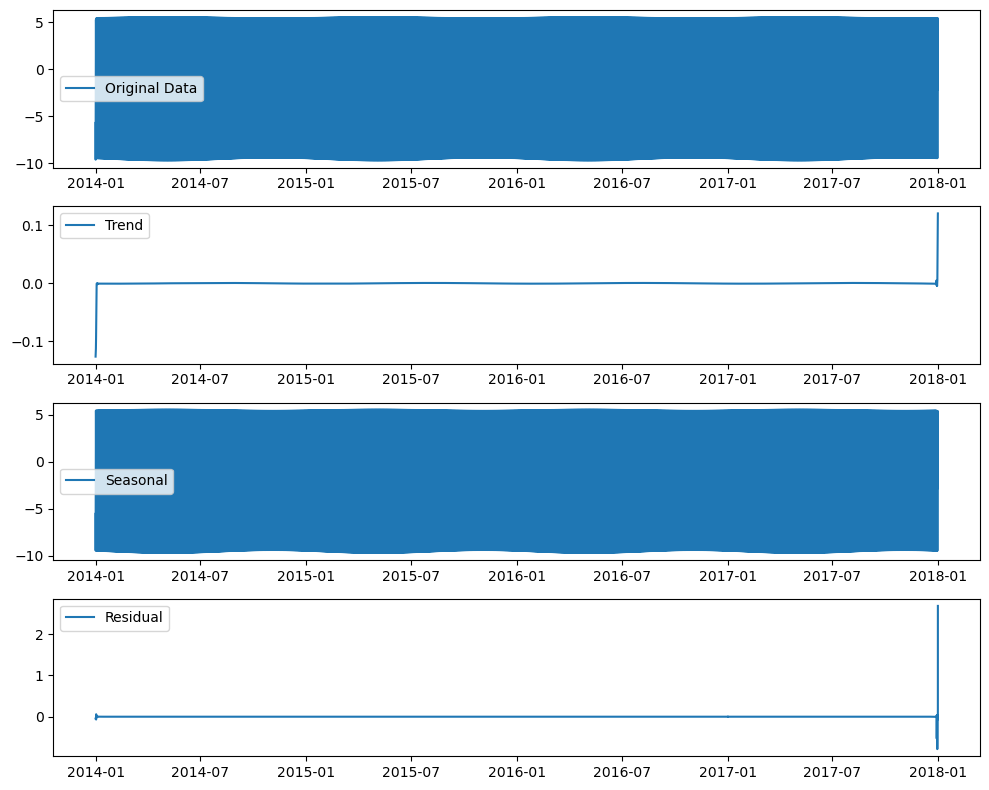

In [51]:
# This cell shows that there is meaning cyclic trend based on a daily period
# There is no linear trend for this time.  
stl3 = STL(df_seasonal['daily_residual'], period=24)
result3 = stl3.fit()

# Plot the decomposition components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df['Date'], df_seasonal['daily_residual'], label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df_seasonal['Date'], result3.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df_seasonal['Date'], result3.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df_seasonal['Date'], result3.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

Shows that only a cyclic trend is in this data (no trend and low error)

### Analysis  

- Overall, this method worked well for deconstructing the data.  Additional efforts need to be made to automate the mathematical model equations.  Using the model_decompose() method might also provide good automation tools.  

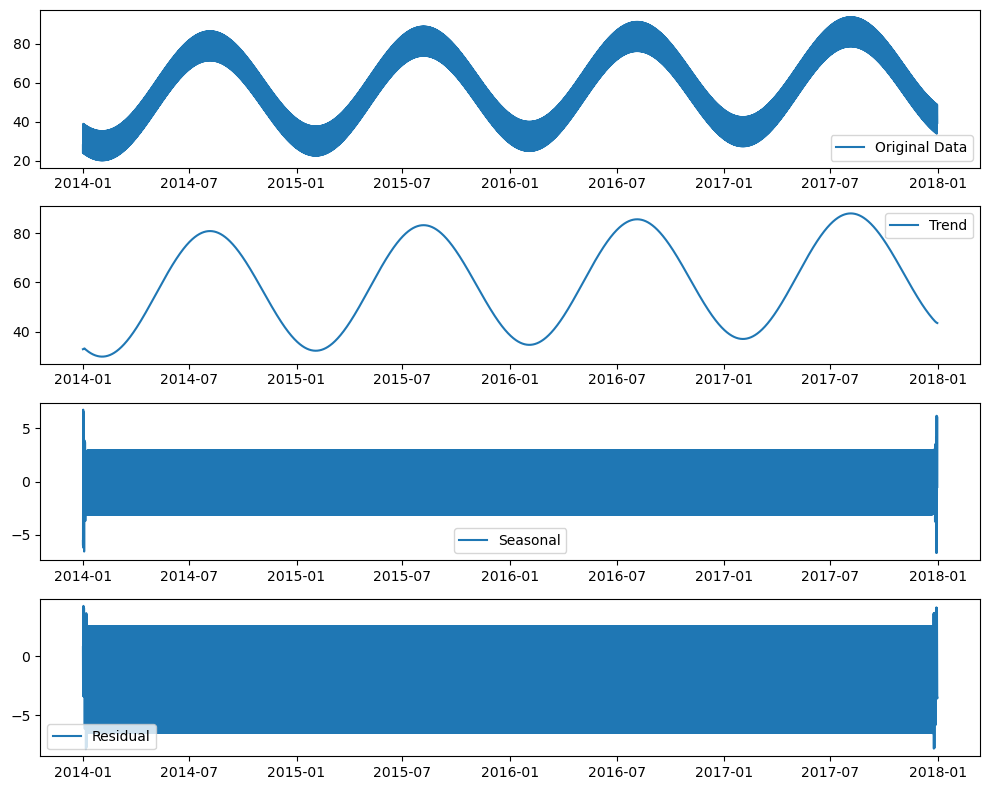

In [52]:
# Note:  This analysis of this cell does not mean anything becasue period=52 just means 2.14 days
#  There is no meaningful trend or cycle and that can be identified by seeing the high residual

stl = STL(df['Temp-Final'], period=52)
result = stl.fit()

# Plot the decomposition components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df['Date'], df['Temp-Final'], label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df['Date'], result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df['Date'], result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df['Date'], result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

## Using Seasonal_Decompose

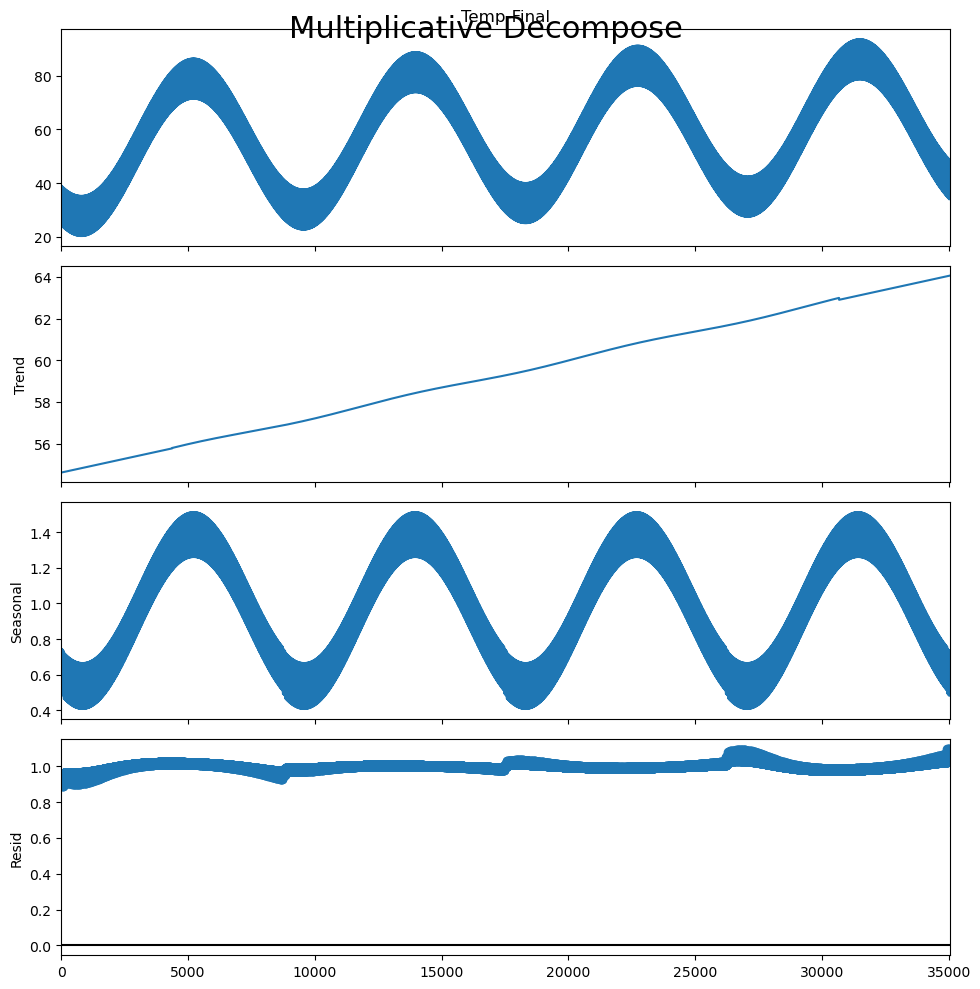

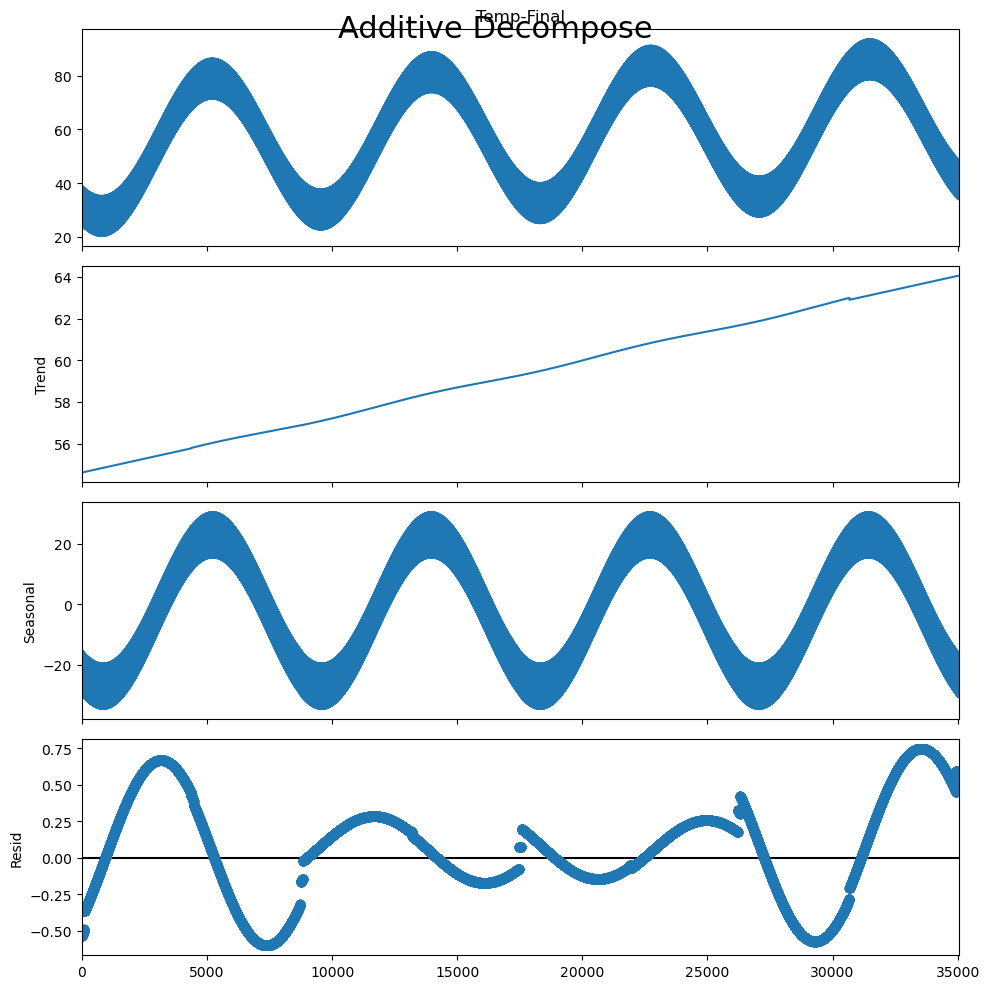

In [56]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Temp-Final'], model='multiplicative', extrapolate_trend='freq', period=8736)

# Additive Decomposition
result_add = seasonal_decompose(df['Temp-Final'], model='additive', extrapolate_trend='freq', period=8736)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Note:  The above does not recognize the cyclic (daily temperature) from the seasonal temperature.  The additive model looks overall better with small errors that are centered around zero.


#### More Multiplicative Analsys

In [8]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2014-01-01 01:00:00,0.894026,33.625484,0.930561,27.974586
2014-01-01 02:00:00,0.857953,33.616182,0.902901,26.040642
2014-01-01 03:00:00,0.821252,33.606879,0.872226,24.073209
2014-01-01 04:00:00,0.857956,33.597577,0.902736,26.021572
2014-01-01 05:00:00,0.894030,33.588274,0.930318,27.936445


<AxesSubplot:xlabel='Date'>

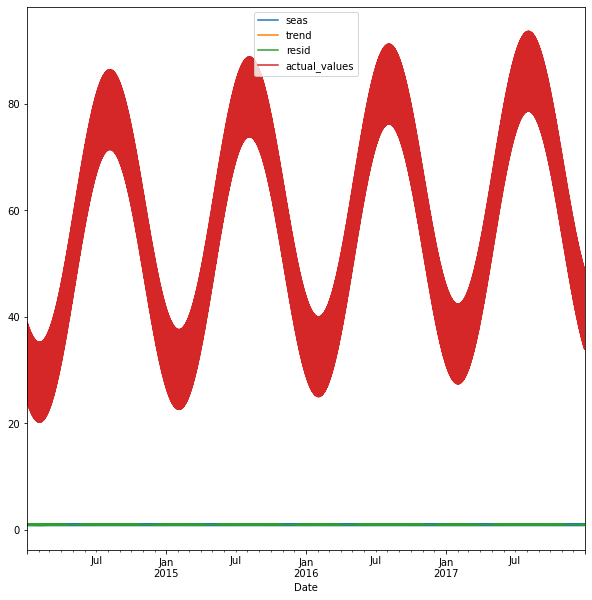

In [9]:
# well, this plot is not too helpful
df_reconstructed.plot()

<AxesSubplot:xlabel='Date'>

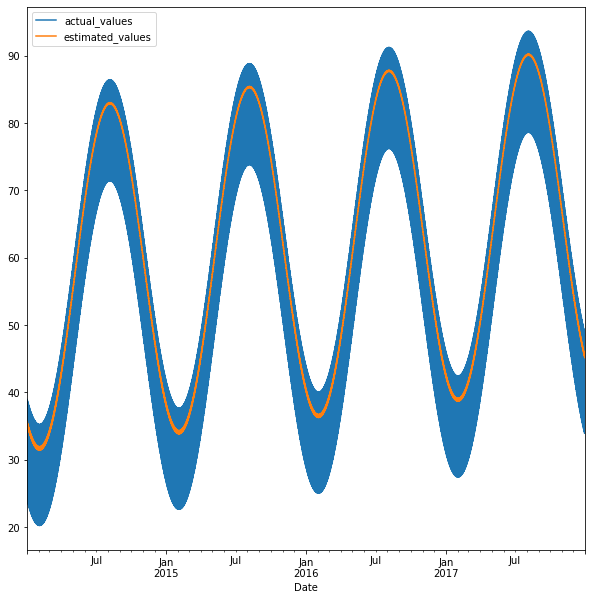

In [10]:
# trying an alternative approach to the above plot
# interesting that the 'seas' component did not show wide variation (see orange line) for each day.  
df_reconstructed['estimated_values'] = df_reconstructed['trend']+df_reconstructed['seas']+df_reconstructed['resid']
df_reconstructed[['actual_values', 'estimated_values']].plot()

#### More Additive Analysis

In [14]:
df_reconstructed2 = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed2.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed2.head()

,seas,trend,resid,actual_values
Date,,,,
2014-01-01 01:00:00,-5.653371,33.625484,0.002473,27.974586
2014-01-01 02:00:00,-7.577764,33.616182,0.002224,26.040642
2014-01-01 03:00:00,-9.535657,33.606879,0.001986,24.073209
2014-01-01 04:00:00,-7.577764,33.597577,0.001759,26.021572
2014-01-01 05:00:00,-5.653372,33.588274,0.001542,27.936445


<AxesSubplot:xlabel='Date'>

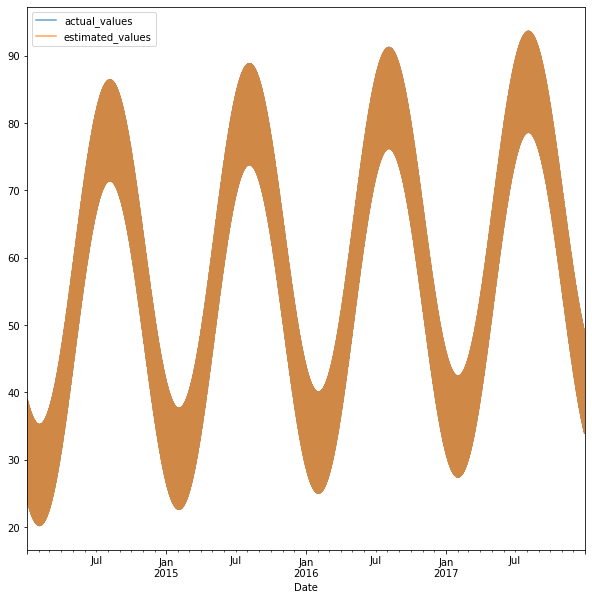

In [18]:
# not very helpful graph
df_reconstructed2['estimated_values'] = df_reconstructed['trend']+df_reconstructed['seas']
df_reconstructed2[['actual_values', 'estimated_values']].plot(alpha=0.7)

In [19]:
df_reconstructed2[['actual_values', 'estimated_values']]

,actual_values,estimated_values
Date,,
2014-01-01 01:00:00,27.974586,27.972113
2014-01-01 02:00:00,26.040642,26.038418
2014-01-01 03:00:00,24.073209,24.071222
2014-01-01 04:00:00,26.021572,26.019813
2014-01-01 05:00:00,27.936445,27.934903
...,...,...
2017-12-30 20:00:00,45.640519,45.638794
2017-12-30 21:00:00,44.337216,44.335267
2017-12-30 22:00:00,42.852441,42.850257


<AxesSubplot:xlabel='Date'>

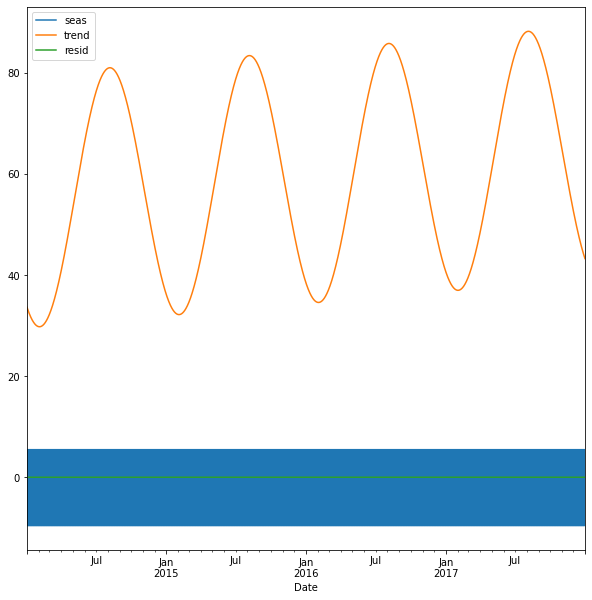

In [21]:
# this is somewhat helpful - it shows the annual trend, daily trend but not the linear trend....
df_reconstructed2.iloc[:,0:3].plot()

This looks very similar to the previous STL method except that it is lacking the linear trend.  I need to check if I made a mistake.  
I will revisit this since I think there are several built in features that I am not utilizing right now.  